In [5]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
import torch
from transformers import BertTokenizer
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler


/Users/paulp/miniforge3/envs/pyto/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
torch.has_mps

True

<h1> Unifying and Formatting Data from multiple corpora </h1>

In [8]:
project_dir = "/Users/paulp/Desktop/UEF/ICLE"
corpus_dir = os.path.join(project_dir, "split_texts")
os.chdir(project_dir)

Link to Clarin website for various learner corpora:
https://www.clarin.eu/resource-families/L2-corpora 

Corpora used on the project include:
1. ICLE 
2. EFCAMDAT (If able to download)
3. 

In [9]:
files = os.scandir(corpus_dir)
nationalities = {}
for a in files:
    b = re.split('-', a.name)[1]
    if b not in nationalities.keys():
        nationalities[b] = 1
    else:
        nationalities[b] += 1
nationalities

{'GE': 281,
 'CN': 757,
 'JP': 365,
 'SW': 255,
 'PO': 350,
 'FIN': 193,
 'TR': 255,
 'RU': 250,
 'SP': 186}

<BarContainer object of 9 artists>

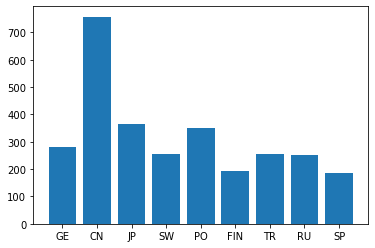

In [10]:
plt.bar(nationalities.keys(), nationalities.values())

A profusion of Chinese data. For training, it would be good to set the number of chinese texts to be comparable with others. Tswana and Italian were eliminated from the corpus: Italian due to data sparsity, and Tswana due to content bias: 100 percent of essays about HIV/AIDS are in the Tswana subcorpus.

In a pinch, the project could be run as binary classification: Chinese / Non-Chinese. Although this does nothing to serve the sparser nationalities, it will more likely lead to accurate results. Consult and consider.

In [11]:
# Create dict for mapping nationalities to integer IDs during training.

target_idx = {}
for a,b in enumerate(nationalities.keys()):
    target_idx[b] = a
target_idx

{'GE': 0,
 'CN': 1,
 'JP': 2,
 'SW': 3,
 'PO': 4,
 'FIN': 5,
 'TR': 6,
 'RU': 7,
 'SP': 8}

In [12]:
dataset = pd.DataFrame(data = None, columns = ['Target', 'Text'])

In [13]:
files = os.scandir(corpus_dir)
for b,a in enumerate(files):
    target = re.split('-', a.name)[1]
    c = open(a)
    text = c.read()
    dataset.loc[b,'Target'] = target
    dataset.loc[b, 'Text'] = text
    c.close()

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [15]:
# tokenized sample
tokenizer(dataset.iloc[1,1], padding = 'max_length', max_length=1024, truncation=True, return_tensors='pt')

{'input_ids': tensor([[  101,   138,  3613, 11820,  1104,  1103,  5671,   118,  2526, 12916,
          1397,  1106,  1139,  3917,  1209,  1437,  1128,  1621,  1103,  2606,
          1104,  1160, 16777,  1104, 19501,  1105,   170, 12411,  1320,  1104,
          6831,   117,  1621,  9182,  1104,  5101,  1105,   170, 21806,  2241,
           113,  1508,  1107,  1175,  1118,  1139,  1711,   117,  1136,  1143,
           114,   117,  1160, 21695,  1105,  1544,  7820,  8675,  1104,  2526,
           119,  1337,  2762,   112,   189,  1315,  2213,   117,   146,  1321,
          1122,   119,  1130,  1412,  1266,   117,  1195,  2222,  1106,  2767,
          1103,  1472,  7553,  1104, 14946,  1112,  1677,  1112,  1936,   117,
          1137,   117,  1106,  1129, 10515,   117,  1112,  1677,  1112,  3253,
          1936,   119,  1422,  1534, 19213,  1103,  3427, 14086,  1116,  1105,
         26063, 13830,  3740, 12411,  4199,  1134,  1132,  1103,  1286,   118,
         17074,  1104,  1177,  1242,  

<h1> Train, Validation, and Test Sets </h1>

Split the data with 80 / 10 / 10.
Check that target classes are represented in each set

help from : https://discuss.pytorch.org/t/train-test-split-using-subsetrandomsampler/105447

In [17]:
train_split = 0.8
val_split = 0.1
test_split = 0.1
data_size = dataset.shape[0]
split = int(np.floor((val_split+test_split)*data_size))


In [18]:
test_val_idxs = np.random.randint(0, data_size, split)
train_idxs = [a for a in range(data_size) if a not in test_val_idxs]
test_idxs = test_val_idxs[:int(np.floor(len(test_val_idxs)/2))]
val_idxs = test_val_idxs[int(np.floor(len(test_val_idxs)/2)):]

In [19]:
dataset['Target'] = pd.Categorical(dataset['Target'])

In [20]:
ds_train = dataset.iloc[train_idxs]
ds_test = dataset.iloc[test_idxs]
ds_val = dataset.iloc[val_idxs]

<BarContainer object of 9 artists>

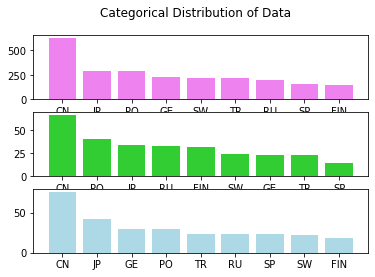

In [21]:
x = ds_train['Target'].value_counts()
y = ds_val['Target'].value_counts()
z = ds_test['Target'].value_counts()

fig, axs = plt.subplots(3)
fig.suptitle('Categorical Distribution of Data')

axs[0].bar(x.axes[0], height=x, color='violet')
axs[1].bar(y.axes[0], height=y, color='limegreen')
axs[2].bar(z.axes[0], height=z, color='lightblue')


#plt.bar(x = sums.axes[0], height = sums)

In [64]:
a = []
for i in range(dataset.shape[0]):
    b = len(tokenizer(dataset.iloc[i,1])['input_ids'])
    a.append(b)

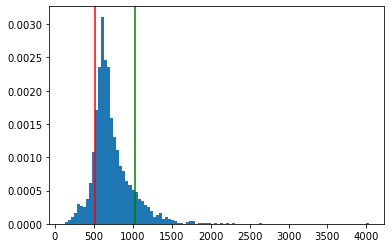

In [34]:
distribution = plt.hist(a, bins=100, density=True, label='Distribution of Text Lengths')
plt.axvline(x=512, color="red")
plt.axvline(x=1024, color='green')

Note that, with a maximum sequence length of 512 (BERT default), quite a lot of data will be lost. When we double the max length, the attention calculations will increase by a power of 2, and the training will take significantly longer, albeit with more of the data taken into account.

I tried (foolishly) with 1536 as max length, and the training sessions took way too long and clogged up the RAM. Lets look at how much text will be lost at 512 and 1024 max lengths:

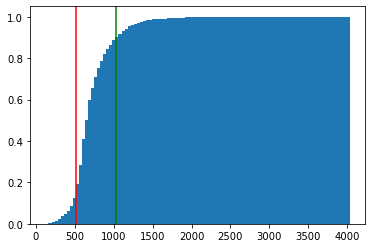

In [36]:
cumulative = plt.hist(a, bins=100, density=True, cumulative=True, label='Distribution of Text Lengths')
plt.axvline(x=1024, color='green')
plt.axvline(x=512, color='red')

This is a bit inaccurate, as it doesn't account for the fact that portions of the larger texts will be used. It looks like at least 90 percent of the data will make it through the trainer at 1024. 

In [25]:
print('max: ', max(a), '\nmin: ', min(a), '\nmean: ', np.mean(a), '\nsd: ', np.sqrt(np.var(a)))

max:  4033 
min:  122 
mean:  726.3025587828492 
sd:  261.69090697933245


In [145]:
b, c, d = [], [], []
for g in a:
    if g<=1024:
        if g<=512:

            b.append(g)
            c.append(g)       
            d.append(g)
        else:
            b.append(512)
            c.append(g)
            d.append(g)
    else:
        b.append(512)
        c.append(1024)
        d.append(g)
        


In [146]:
data = {
    '<=512' : b,
    '<=1024' : c,
    '>1024' : d
}

d = pd.DataFrame(data)

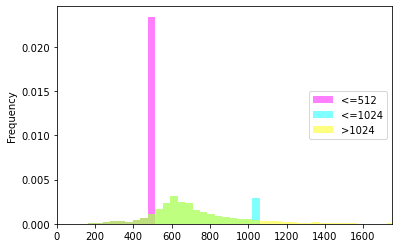

In [147]:
d.plot.hist(bins = 100, 
            density=True, 
            stacked=False, 
            xlim=[0,1750], 
            alpha=0.5,
            color=['magenta', 'cyan', 'yellow']
           )
plt.legend(loc=7)

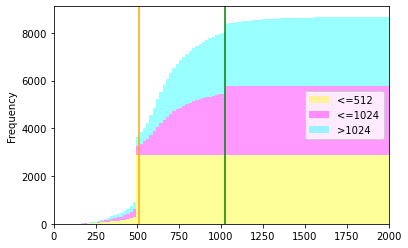

In [148]:
d.plot.hist(bins = 200, 
            cumulative = True, 
            density=False, 
            stacked=True, 
            alpha=0.4, 
            xlim=[0,2000],
            color=['yellow','magenta', 'cyan']
           )
plt.legend(loc=7)
plt.axvline(x=512, color='orange')
plt.axvline(x=1024, color='green')

In [149]:
col_sums = d.sum(axis=0)
col_sums

<=512     1443374
<=1024    2021244
>1024     2100467
dtype: int64

In [150]:
# Percentage of tokens captured in each threshold group
percent_total_tokens = col_sums / sum(a)
percent_total_tokens

<=512     0.687168
<=1024    0.962283
>1024     1.000000
dtype: float64

In [113]:
sum(a)

2100467

Certainly it looks like 512 is far too short: there would be massive data loss. This is problematic in that we are already data-sparse with 9 categories for prediction. We will lose ~4% of the tokens at 1024, which is still significant but far improved.

<h1>Data Loader</h1>

help from: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [154]:
# custom dataset class wrappe around torch.utils dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [target_idx[a] for a in df['Target']]
        self.texts = [tokenizer.encode_plus(text,
                                add_special_tokens=True,
                                max_length=1024,
                                truncation=True,
                                pad_to_max_length=True,
                                return_attention_mask = True,
                                return_tensors='pt') 
                      for text in dataset.loc[:,'Text']]
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [155]:
ds = Dataset(dataset)

In [156]:
[target_idx[a] for a in dataset['Target']]

[0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 5,
 6,
 4,
 0,
 1,
 6,
 7,
 1,
 4,
 7,
 1,
 4,
 8,
 5,
 2,
 6,
 4,
 0,
 7,
 6,
 6,
 2,
 4,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 7,
 4,
 1,
 3,
 2,
 1,
 3,
 0,
 3,
 4,
 8,
 1,
 7,
 2,
 6,
 1,
 7,
 1,
 7,
 1,
 3,
 1,
 5,
 1,
 7,
 8,
 2,
 4,
 1,
 6,
 4,
 6,
 6,
 5,
 4,
 2,
 4,
 5,
 6,
 1,
 4,
 6,
 4,
 3,
 2,
 1,
 8,
 0,
 1,
 3,
 8,
 7,
 7,
 1,
 7,
 8,
 1,
 1,
 7,
 6,
 2,
 8,
 1,
 8,
 4,
 5,
 6,
 1,
 3,
 2,
 4,
 6,
 1,
 0,
 1,
 8,
 0,
 7,
 0,
 8,
 4,
 1,
 0,
 1,
 4,
 1,
 4,
 5,
 2,
 8,
 7,
 0,
 3,
 2,
 7,
 7,
 8,
 1,
 3,
 1,
 5,
 2,
 1,
 5,
 1,
 6,
 1,
 7,
 1,
 8,
 3,
 4,
 8,
 2,
 2,
 4,
 7,
 1,
 6,
 0,
 2,
 1,
 2,
 5,
 3,
 1,
 0,
 0,
 3,
 1,
 5,
 2,
 1,
 1,
 2,
 1,
 7,
 5,
 7,
 6,
 5,
 4,
 6,
 1,
 6,
 3,
 2,
 7,
 8,
 0,
 2,
 8,
 7,
 0,
 7,
 1,
 3,
 6,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 4,
 8,
 3,
 0,
 2,
 0,
 3,
 1,
 0,
 3,
 7,
 1,
 3,
 6,
 2,
 1,
 7,
 1,
 6,
 1,
 6,
 4,
 4,
 2,
 4,
 5,
 1,
 8,
 3,
 8,
 1,
 0,
 1,
 0,
 3,
 1,
 0,
 1,
 2,
 0,
 0,
 0,


In [157]:
#check that this returns appropriate values
trial = Dataset(ds_train)
trial.__getitem__(0)

({'input_ids': tensor([[101, 146, 112,  ...,   0,   0,   0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])},
 array(0))

In [158]:
#create the dataset objects
ds_tr = Dataset(ds_train)
ds_vl = Dataset(ds_val)
ds_ts = Dataset(ds_test)

In [159]:
#test some of the methods
ds_tr.get_batch_labels(10)

array(4)

In [160]:
ds_tr.get_batch_texts(10)

{'input_ids': tensor([[ 101, 1109, 3750,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}

In [161]:
ds_train.shape

(2363, 2)

<h1> Model </h1>

Skip the following implementation and go to Approach 2

In [322]:
from torch import nn
from transformers import BertModel

In [355]:
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

This is a BERT for text classification implementation: 
Might it be better to pretrain the model on the corpus first, then do a task-specific fine-tune?

In [419]:
def train(model, train_data, val_data, learning_rate, epochs):
    
    stats = pd.DataFrame(columns = ['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])
    train, val = Dataset(ds_train), Dataset(ds_val)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    # for mac M1, device is 'mps' instead of 'cuda'
    use_mps = torch.backends.mps.is_available()
    device = torch.device('mps' if use_mps else 'cpu')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = learning_rate)
    scheduler = ReduceLROnPlateau(optimizer = optimizer, mode= 'min', patience=2, verbose=True)
    
    if use_mps:
        model = model.to(device)
        criterion = criterion.to(device)
        
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
        
        scheduler.step(total_loss_val)
                
        stats.loc[epoch_num, 'Epoch'] = epoch_num + 1
        stats.loc[epoch_num, 'Train Loss'] = np.around(total_loss_train/len(train_data), 3)
        stats.loc[epoch_num, 'Train Accuracy'] = np.around(total_acc_train/len(train_data), 3)
        stats.loc[epoch_num, 'Val Loss'] = np.around(total_loss_val/len(val_data), 3)
        stats.loc[epoch_num, 'Val Accuracy'] = np.around(total_acc_val/len(val_data), 3)
        
    return stats

In [420]:
N_EPOCHS = 10
model = BertClassifier()
LR = 1e-2

stats = train(model, ds_train, ds_val, LR, N_EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

 15%|██████▏                                 | 183/1186 [02:54<15:41,  1.07it/s]


 32%|████████████▋                           | 377/1186 [05:56<12:40,  1.06it/s]


 48%|███████████████████▎                    | 571/1186 [08:58<09:36,  1.07it/s]


 65%|█████████████████████████▊              | 765/1186 [12:00<06:35,  1.07it/s]


 81%|████████████████████████████████▎       | 959/1186 [15:03<03:33,  1.06it/s]


 97%|█████████████████████████████████████▉ | 1153/1186 [18:05<00:30,  1.07it/s]


100%|███████████████████████████████████████| 1186/1186 [18:36<00:00,  1.06it/s]

 13%|█████▍                                  | 160/1186 [02:29<16:02,  1.07it/s]


 30%|███████████▉                            | 354/1186 [05:31<13:00,  1.07it/s]


 46%|██████████████████▍                     | 548/1186 [08:33<09:56,  1.07it/s]


 63%|█████████████████████████               | 742/1186 [11:35<06:55,  1.07it/s]


 79%|███████████████████████████████▌        | 936/1186 [14:37<03:54,  1.06it/s]


 95%|█████████████████████████████████████▏ | 1130/1186 [17:57<00:58,  1.04s/it]


100%|███████████████████████████████████████| 1186/1186 [18:55<00:00,  1.04it/s]

 12%|████▌                                   | 137/1186 [02:22<18:08,  1.04s/it]


 28%|███████████▏                            | 331/1186 [05:44<14:47,  1.04s/it]


 44%|█████████████████▋                      | 525/1186 [09:06<11:28,  1.04s/it]


 61%|████████████████████████▏               | 719/1186 [12:28<08:05,  1.04s/it]


 77%|██████████████████████████████▊         | 913/1186 [15:50<04:44,  1.04s/it]


 93%|████████████████████████████████████▍  | 1107/1186 [19:11<01:22,  1.04s/it]


100%|███████████████████████████████████████| 1186/1186 [20:33<00:00,  1.04s/it]

 10%|███▊                                    | 114/1186 [01:58<18:33,  1.04s/it]


 26%|██████████▍                             | 308/1186 [05:20<15:17,  1.05s/it]


 42%|████████████████▉                       | 502/1186 [08:42<11:53,  1.04s/it]


 59%|███████████████████████▍                | 696/1186 [12:03<08:29,  1.04s/it]


 75%|██████████████████████████████          | 890/1186 [15:16<04:31,  1.09it/s]


 91%|███████████████████████████████████▋   | 1084/1186 [18:14<01:33,  1.09it/s]


100%|███████████████████████████████████████| 1186/1186 [19:47<00:00,  1.00s/it]


Epoch 00004: reducing learning rate of group 0 to 1.0000e-03.



 16%|██████▌                                 | 193/1186 [02:56<15:10,  1.09it/s]


 33%|█████████████                           | 387/1186 [05:54<12:11,  1.09it/s]


 49%|███████████████████▌                    | 581/1186 [08:52<09:14,  1.09it/s]


 65%|██████████████████████████▏             | 775/1186 [11:50<06:16,  1.09it/s]


 82%|████████████████████████████████▋       | 969/1186 [14:48<03:18,  1.09it/s]


 98%|██████████████████████████████████████▏| 1163/1186 [17:46<00:21,  1.09it/s]


100%|███████████████████████████████████████| 1186/1186 [18:06<00:00,  1.09it/s]

 14%|█████▋                                  | 170/1186 [02:35<15:26,  1.10it/s]


 31%|████████████▎                           | 364/1186 [05:33<12:31,  1.09it/s]


 47%|██████████████████▊                     | 558/1186 [08:31<09:34,  1.09it/s]


 63%|█████████████████████████▎              | 752/1186 [11:29<06:37,  1.09it/s]


 80%|███████████████████████████████▉        | 946/1186 [14:26<03:40,  1.09it/s]


 96%|█████████████████████████████████████▍ | 1140/1186 [17:24<00:42,  1.09it/s]


100%|███████████████████████████████████████| 1186/1186 [18:06<00:00,  1.09it/s]

 12%|████▉                                   | 147/1186 [02:14<15:52,  1.09it/s]


 29%|███████████▌                            | 341/1186 [05:12<12:54,  1.09it/s]


 45%|██████████████████                      | 535/1186 [08:10<09:55,  1.09it/s]


 61%|████████████████████████▌               | 729/1186 [11:08<06:58,  1.09it/s]


 78%|███████████████████████████████▏        | 923/1186 [14:05<04:01,  1.09it/s]


 94%|████████████████████████████████████▋  | 1117/1186 [17:08<01:04,  1.07it/s]


100%|███████████████████████████████████████| 1186/1186 [18:13<00:00,  1.08it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.



 16%|██████▌                                 | 193/1186 [03:01<15:32,  1.06it/s]


 33%|█████████████                           | 387/1186 [06:03<12:31,  1.06it/s]


 49%|███████████████████▌                    | 581/1186 [09:05<09:27,  1.07it/s]


 65%|██████████████████████████▏             | 775/1186 [12:07<06:25,  1.07it/s]


 82%|████████████████████████████████▋       | 969/1186 [15:09<03:23,  1.07it/s]


 98%|██████████████████████████████████████▏| 1163/1186 [18:23<00:23,  1.03s/it]


100%|███████████████████████████████████████| 1186/1186 [18:46<00:00,  1.05it/s]

 14%|█████▋                                  | 170/1186 [02:57<17:31,  1.04s/it]


 31%|████████████▎                           | 364/1186 [06:18<14:12,  1.04s/it]


 47%|██████████████████▊                     | 558/1186 [09:40<10:57,  1.05s/it]


 63%|█████████████████████████▎              | 752/1186 [13:02<07:28,  1.03s/it]


 80%|███████████████████████████████▉        | 946/1186 [16:24<04:10,  1.05s/it]


 96%|█████████████████████████████████████▍ | 1140/1186 [19:46<00:48,  1.06s/it]


100%|███████████████████████████████████████| 1186/1186 [20:34<00:00,  1.04s/it]

 12%|████▉                                   | 147/1186 [02:33<17:54,  1.03s/it]


 29%|███████████▌                            | 341/1186 [05:54<14:43,  1.05s/it]


 45%|██████████████████                      | 535/1186 [09:16<11:26,  1.05s/it]


 61%|████████████████████████▌               | 729/1186 [12:38<07:53,  1.04s/it]


 78%|███████████████████████████████▏        | 923/1186 [15:46<04:08,  1.06it/s]


 94%|████████████████████████████████████▋  | 1117/1186 [18:48<01:04,  1.07it/s]


100%|███████████████████████████████████████| 1186/1186 [19:53<00:00,  1.01s/it]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.


In [421]:
stats

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,inf,0.096,1.102,0.107
1,2,1.099,0.096,1.102,0.107
2,3,1.099,0.096,1.102,0.107
3,4,1.099,0.096,1.102,0.107
4,5,1.099,0.096,1.102,0.107
5,6,1.099,0.096,1.102,0.107
6,7,1.099,0.096,1.102,0.107
7,8,1.099,0.096,1.102,0.107
8,9,1.099,0.096,1.102,0.107
9,10,1.099,0.096,1.102,0.107


In [424]:
def evaluate(model, test_data):
    test = Dataset(ds_test)
    
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_mps = torch.backends.mps.is_available()
    device = torch.device('mps' if use_mps else 'cpu')
    if use_mps:
        model = model.to(device)
    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
    print(f'Test Accuracy: {total_acc_test/len(test_data): .3f}')

In [425]:
evaluate(model, ds_ts)

Test Accuracy:  0.111


In [354]:
torch.save(model, os.path.join(project_dir, 'model_1'))

<h1> Approach 2 </h1>

Using a pretrained model, do additional pretraining on the corpus itself.
After pretraining, use the resulting model and repeat Approach 1.

help from : https://d2l.ai/chapter_natural-language-processing-pretraining/bert-pretraining.html 

In [ ]:
from d2l import torch as d2l #what is this?

In [359]:
def _get_batch_loss_bert(net, loss, vocab_size, 
                         tokens_X, setments_X, valid_lens_x, 
                         pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y):
    #forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    
    #Masked Language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1), vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1,1)
    mlm_l = mlm_l.sum()/(mlm_weights_X.sum() + 1e-8)
    
    #Next-sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_1
    
    return mlm_1, nsp_l, l

SyntaxError: unmatched ')' (3866030830.py, line 6)

In [477]:
from transformers import BertConfig
from transformers import BertForPreTraining

In [462]:
config = BertConfig.from_pretrained('bert-base-cased')

In [484]:
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [466]:
device

device(type='mps')

In [467]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [470]:
dataset.head()

,Target,Text
0,GE,\nI've been making music now for 20 years. You...
1,GE,\nA quick inspection of the waste-paper basket...
2,CN,\nRecycling of waste has long been a controver...
3,CN,"\nFew years age, government in some cities suc..."
4,JP,"\nGender discrimination. These Days, we often ..."


In [472]:
sample = tokenizer.tokenize(dataset['Text'].iloc[0])

In [478]:
help(BertForPreTraining)

Help on class BertForPreTraining in module transformers.models.bert.modeling_bert:

class BertForPreTraining(BertPreTrainedModel)
 |  BertForPreTraining(config)
 |  
 |  Bert Model with two heads on top as done during the pretraining: a `masked language modeling` head and a `next
 |  sentence prediction (classification)` head.
 |  
 |  
 |  This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
 |  library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
 |  etc.)
 |  
 |  This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
 |  Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
 |  and behavior.
 |  
 |  Parameters:
 |      config ([`BertConfig`]): Model configuration class with all the parameters of the model.
 |          Initializing with a config file

In [485]:
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [502]:
config = BertConfig.from_dict(custom)

<h1> Easiest Implementation So Far </h1>

Help from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [170]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
device = torch.device('mps')
MAX_LEN = 1024

In [164]:
#tokenize, covert to ids, and generate mask tensor

input_ids =[]
attn_masks = []
for text in dataset.loc[:,'Text']:
    d = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = MAX_LEN,
        pad_to_max_length = True,
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(d['input_ids'])
    attn_masks.append(d['attention_mask'])

In [165]:
#we shouldn't need these if we use the Dataset() class from above
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)
labels = torch.tensor([target_idx[a] for a in dataset.loc[:,'Target']])

In [2]:
import random
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

/Users/paulp/miniforge3/envs/pyto/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [197]:
ds_pretrain = TensorDataset(input_ids, attn_masks, labels)

In [198]:
train_size = int(0.92*len(labels))
val_size = len(labels) - train_size

ds_tr, ds_vl = random_split(ds_pretrain, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,660 training samples
  232 validation samples


In [199]:
batch_size = 2

train_dataloader = DataLoader(
    ds_tr, 
    sampler = RandomSampler(ds_tr), 
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    ds_vl,
    sampler = SequentialSampler(ds_vl),
    batch_size = batch_size)



In [4]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = 9,
    output_attentions = False,
    output_hidden_states = False,
    max_position_embeddings = 512,
    ignore_mismatched_sizes=True,
    return_dict = False,
    attention_probs_dropout_prob = 0.03,
    hidden_dropout_prob = 0.00
)

model.to(device)
model.config

KeyError: 'bert.embeddings.LayerNorm.weight'

In [210]:
epochs = 2
LR = 1e-5
n_warmup = 300

total_steps = len(train_dataloader)*epochs
optimizer = torch.optim.AdamW(model.parameters(), lr = LR, eps = 1e-8, )
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = n_warmup,
                                           num_training_steps = total_steps)

#trying something different...
#scheduler = ReduceLROnPlateau(optimizer = optimizer, mode= 'min', patience=2, verbose=True)

In [211]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [212]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [213]:
# run this to empty out the training data when running new models
training_stats = []

In [214]:


total_t0 = time.time()

for j in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(j + 1, epochs))
    print('Training...')
    t0 = time.time()
    # Reset loss
    total_train_loss = 0
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step%40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        
        total_train_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        scheduler.step()
        
        
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    training_time = format_time(time.time() - t0)
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    # Validation
    
    print("")
    print("Running Validation...")

    t0 = time.time()
    
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            loss, logits = model(b_input_ids, 
                                   token_type_ids = None, 
                                   attention_mask = b_input_mask, 
                                   labels = b_labels)
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
#    scheduler.step(avg_val_loss)
    
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': j + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 8 ========
Training...
  Batch    40  of  1,330.    Elapsed: 0:04:58.
  Batch    80  of  1,330.    Elapsed: 0:09:44.
  Batch   120  of  1,330.    Elapsed: 0:14:32.
  Batch   160  of  1,330.    Elapsed: 0:19:23.
  Batch   200  of  1,330.    Elapsed: 0:24:28.
  Batch   240  of  1,330.    Elapsed: 0:29:37.
  Batch   280  of  1,330.    Elapsed: 0:34:47.
  Batch   320  of  1,330.    Elapsed: 0:39:54.
  Batch   360  of  1,330.    Elapsed: 0:45:01.
  Batch   400  of  1,330.    Elapsed: 0:50:10.
  Batch   440  of  1,330.    Elapsed: 0:55:23.
  Batch   480  of  1,330.    Elapsed: 1:00:31.
  Batch   520  of  1,330.    Elapsed: 1:05:17.
  Batch   560  of  1,330.    Elapsed: 1:10:05.
  Batch   600  of  1,330.    Elapsed: 1:14:52.
  Batch   640  of  1,330.    Elapsed: 1:19:42.
  Batch   680  of  1,330.    Elapsed: 1:24:31.
  Batch   720  of  1,330.    Elapsed: 1:29:19.
  Batch   760  of  1,330.    Elapsed: 1:34:07.
  Batch   800  of  1,330.    Elapsed: 1:38:56.
  Batch   840  of

  Batch 1,040  of  1,330.    Elapsed: 2:16:10.
  Batch 1,080  of  1,330.    Elapsed: 2:21:16.
  Batch 1,120  of  1,330.    Elapsed: 2:26:22.
  Batch 1,160  of  1,330.    Elapsed: 2:31:35.
  Batch 1,200  of  1,330.    Elapsed: 2:36:38.
  Batch 1,240  of  1,330.    Elapsed: 2:41:41.
  Batch 1,280  of  1,330.    Elapsed: 2:46:47.
  Batch 1,320  of  1,330.    Elapsed: 2:51:59.

  Average training loss: 2.11
  Training epcoh took: 2:53:22

Running Validation...
  Accuracy: 0.25
  Validation Loss: 2.12
  Validation took: 0:01:10

======== Epoch 6 / 8 ========
Training...
  Batch    40  of  1,330.    Elapsed: 0:05:18.
  Batch    80  of  1,330.    Elapsed: 0:10:42.
  Batch   120  of  1,330.    Elapsed: 0:15:58.
  Batch   160  of  1,330.    Elapsed: 0:21:09.
  Batch   200  of  1,330.    Elapsed: 0:26:26.
  Batch   240  of  1,330.    Elapsed: 0:31:36.
  Batch   280  of  1,330.    Elapsed: 0:36:47.
  Batch   320  of  1,330.    Elapsed: 0:42:04.
  Batch   360  of  1,330.    Elapsed: 0:47:17.
  Bat

KeyboardInterrupt: 

In [ ]:
torch.save(model, 'model_4.pt')

In [203]:
training_stats

[{'epoch': 1,
  'Training Loss': 12.895850280236646,
  'Valid. Loss': 9.569510728120804,
  'Valid. Accur.': 0.08620689655172414,
  'Training Time': '1:55:04',
  'Validation Time': '0:01:07'},
 {'epoch': 2,
  'Training Loss': 13.963508516767574,
  'Valid. Loss': 7.285719164486589,
  'Valid. Accur.': 0.07758620689655173,
  'Training Time': '1:56:44',
  'Validation Time': '0:01:07'},
 {'epoch': 3,
  'Training Loss': inf,
  'Valid. Loss': 13.961130482626372,
  'Valid. Accur.': 0.06896551724137931,
  'Training Time': '1:56:21',
  'Validation Time': '0:01:07'}]

NameError: name 'stats_epoch_1' is not defined

In [187]:
n = iter(train_dataloader)

In [192]:
len(next(n)[0][0]) #this looks right

1024

In [675]:
ids, msk, lbl = next(n)
ids= ids.to(device)
msk = msk.to(device)
lbl = lbl.to(device)

In [676]:
output_sample = model(ids, token_type_ids=None, attention_mask = msk, labels = lbl)

In [688]:
output_sample.loss

tensor(1.9900, device='mps:0', grad_fn=<NllLossBackward0>)

In [686]:
output_sample[0]

tensor(1.9900, device='mps:0', grad_fn=<NllLossBackward0>)

In [685]:
type(output_sample[0])

torch.Tensor

In [681]:
type(output_sample[0].item()) #this is a float, so why does the error give 'str'

float

In [682]:
output_sample[1] #this should be 9 logits * 2 batches --- good

tensor([[-0.4347, -0.0733,  0.3435, -0.4055,  0.0714,  0.3792,  0.4217,  0.3316,
         -0.2395],
        [-0.6573, -0.0727,  0.2864, -0.1448, -0.1026,  0.1593,  0.2555,  0.1728,
         -0.2766]], device='mps:0', grad_fn=<MpsLinearBackward0>)

In [615]:
ds_tr.__getitem__(10)[2]

tensor(8)

In [660]:
help(validation_dataloader)

Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: int = 2, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process 

In [574]:
model(ds_tr.__getitem__(10)[0], 
      token_type_ids = None, 
      attention_mask = ds_tr.__getitem__(10)[1], 
      labels = ds_tr.__getitem__(10)[2])
      

ValueError: not enough values to unpack (expected 2, got 1)